# Home Insurance - Predictiong Insurance claims


## Data & Preperations




### Import Libreries


---



In [ ]:
import warnings
warnings.filterwarnings('ignore') #Ignore warning

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling
from imblearn.pipeline import Pipeline
import math

from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, classification_report, f1_score, recall_score, precision_score, log_loss, make_scorer


from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import preprocessing
from sklearn.externals.six import StringIO

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from collections import Counter

import pydot
from IPython.display import Image

import statsmodels.api as sm


### Import the data


---



In [ ]:
def csv_drive_path_generatoer(url):
 '''
 Help in read csv file directly from google drive.
 Make sure the csv format is standard.
 url:str - path to csv file example:
   url = 'https://drive.google.com/file/d/126JPZ3lYwdLyJ2d_7jxM9jMtZaOlF-Ld/view?usp=sharing'
 return : str
 '''
 path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
 return path

In [ ]:
path = csv_drive_path_generatoer('https://drive.google.com/file/d/1Y31Z550h3Achx_CYn0JtpuVVBK9bCRlL/view?usp=sharing')
df_raw = pd.read_csv(path)

### EDA


---



In [ ]:
df_raw.head()

,id,state,postal_code,product,user_id,square_ft,high_risk_dog,has_fire_alarm,has_burglar_alarm,portable_electronics,coast,fire_housing_proximity,previous_policies,user_age,card_type,target
0,2.492010e+18,NM,87043,ho4,-9.160050e+18,NaN,0,True,True,0.0,NaN,5,0,39.0,credit,False
1,8.860750e+17,WI,53715,ho4,-8.929000e+18,NaN,0,True,False,1.0,30.0,1,0,19.0,debit,False
2,5.527290e+18,WI,53211,ho4,-9.015980e+18,NaN,0,True,False,1.0,1.0,1,0,20.0,debit,True
3,6.453400e+18,NM,88012,ho4,-9.060030e+18,NaN,0,True,True,1.0,NaN,1,0,33.0,debit,False
4,-8.836390e+18,AR,72116,ho4,-8.801720e+18,NaN,0,False,False,1.0,NaN,1,0,20.0,debit,False


In [ ]:
print(df_raw.shape)
#Total records = 12397 over 16 columns
print('--------------------------------------------------------------------------')
print(df_raw.info() )

(12397, 16)
--------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12397 entries, 0 to 12396
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      12397 non-null  float64
 1   state                   12397 non-null  object 
 2   postal_code             12397 non-null  int64  
 3   product                 12397 non-null  object 
 4   user_id                 12397 non-null  float64
 5   square_ft               279 non-null    float64
 6   high_risk_dog           12397 non-null  int64  
 7   has_fire_alarm          12397 non-null  bool   
 8   has_burglar_alarm       12397 non-null  bool   
 9   portable_electronics    11990 non-null  float64
 10  coast                   11242 non-null  float64
 11  fire_housing_proximity  12397 non-null  object 
 12  previous_policies       12397 non-null  int64  
 13  user

In [ ]:
df_raw.describe()

,id,postal_code,user_id,square_ft,high_risk_dog,portable_electronics,coast,previous_policies,user_age
count,1.239700e+04,12397.000000,1.239700e+04,279.000000,12397.0,11990.000000,11242.000000,12397.000000,12315.000000
mean,-1.303499e+16,62576.877309,-9.009474e+18,1457.498208,0.0,0.336364,17.839619,0.237961,31.085668
std,5.326267e+18,32553.186912,1.237394e+17,728.877297,0.0,0.472485,12.128988,0.527252,10.000254
min,-9.221130e+18,2840.000000,-9.223350e+18,100.000000,0.0,0.000000,0.000000,0.000000,17.000000
25%,-4.604830e+18,30084.000000,-9.117380e+18,850.000000,0.0,0.000000,4.000000,0.000000,24.000000
50%,-2.537840e+16,77006.000000,-9.009450e+18,1350.000000,0.0,0.000000,20.000000,0.000000,29.000000
75%,4.593520e+18,91367.000000,-8.902650e+18,1907.500000,0.0,1.000000,30.000000,0.000000,35.000000
max,9.222860e+18,97702.000000,-8.796310e+18,4478.000000,0.0,1.000000,30.000000,7.000000,112.000000


In [ ]:
#Check for Null
df_raw.isnull().sum()

id                            0
state                         0
postal_code                   0
product                       0
user_id                       0
square_ft                 12118
high_risk_dog                 0
has_fire_alarm                0
has_burglar_alarm             0
portable_electronics        407
coast                      1155
fire_housing_proximity        0
previous_policies             0
user_age                     82
card_type                    52
target                        0
dtype: int64

In [ ]:
df_raw.dtypes

id                        float64
state                      object
postal_code                 int64
product                    object
user_id                   float64
square_ft                 float64
high_risk_dog               int64
has_fire_alarm               bool
has_burglar_alarm            bool
portable_electronics      float64
coast                     float64
fire_housing_proximity     object
previous_policies           int64
user_age                  float64
card_type                  object
target                       bool
dtype: object

In [ ]:
#Check Data balancing:

df_raw['target'].value_counts(normalize = True)

#The data is very much imbalanced. The majority class belongs to False label 
# Later we will label it as 0 and the minority class which belongs to True label we will label it as 1.

False    0.977333
True     0.022667
Name: target, dtype: float64

In [ ]:
#Duplicate records

print('Duplicate Records: %.f' %df_raw[df_raw.duplicated()].size ) #=0
print('----------------------------------------------------------------------------------')
print(df_raw[df_raw.duplicated('id')].sort_values('id' , axis=0 , ascending=True) )

#The ID have duplicate values, But we decided NOT to drop the records, as from the data it looks like they belong to differant polices. And also there are 2 'True' records which are valuble.
#The ID will be dropped later

Duplicate Records: 0
----------------------------------------------------------------------------------
                 id state  postal_code  ... user_age  card_type  target
9313  -7.748870e+18    TX        79606  ...     36.0      debit   False
9210  -7.559100e+18    TX        75010  ...     30.0      debit   False
6393  -6.661250e+18    NY        11211  ...     29.0      debit   False
10913 -6.601360e+18    TX        78130  ...     29.0    prepaid   False
4735  -6.564950e+18    IL        60622  ...     32.0      debit   False
7442  -6.298500e+18    NY        10009  ...     30.0     credit   False
7541  -5.826480e+18    NY        10706  ...     37.0      debit   False
11203 -5.087000e+18    TX        76107  ...     24.0      debit   False
7824  -4.157380e+18    NY        11211  ...     30.0     credit   False
8130  -3.701010e+18    NY        10601  ...     27.0     credit   False
7440  -3.533880e+18    NY        10463  ...     40.0      debit   False
10403 -2.822790e+18    TX       

In [ ]:
print('State categories: %f' %df_raw['state'].nunique() )

State categories: 21.000000


In [ ]:
df_raw['card_type'].value_counts()

debit      7131
credit     5029
prepaid     185
Name: card_type, dtype: int64

In [ ]:
df_raw['product'].value_counts()

ho4    12127
ho6      153
ho3      117
Name: product, dtype: int64

In [ ]:
df_raw['fire_housing_proximity'].value_counts()
#Contains some errors

1     6391
2     3574
3     1616
4      595
5      171
6       27
7        6
5X       3
8B       3
7X       3
4Y       2
5Y       2
8        2
4X       1
6Y       1
Name: fire_housing_proximity, dtype: int64

In [ ]:
df_raw['previous_policies'].value_counts()

0    9898
1    2152
2     275
3      48
4      19
5       3
7       1
6       1
Name: previous_policies, dtype: int64

In [ ]:
 df_raw['has_fire_alarm'].value_counts()

True     9395
False    3002
Name: has_fire_alarm, dtype: int64

### Preparing the Features



**Key guide lines to deciding which features to keep & which to Drop:**

1.   leaks information from the future (After the claim was True) or Data which is not availble when new record arrives
2.   doesn’t affect the state of the claim  (ex: randomly generated ID value)
3.   Features which are formatted poorly
4.   requires more data or a lot of pre-processing to turn into useful a feature
5.   contains redundant information.








In [ ]:
# [id] - generated ID value - DROP
# [user_id] generated ID value - DROP
# [sqaure_ft] - have very few valid records - DROP
# [card_type] - doesn't affect the state of the claim (Assuming how the user pays for the policy has nothing to do if he might file a claim or not) - DROP
# [product] - Is very imbalanced, And also The Assumption is that our module will be used to sell the suitble product to the customer, based on the propability of him filing a claim - DROP
# [high_risk_dog] - contain only '0' - DROP

# [portable_electronics]  - policy covers valuble portable electronics - Have missing values, **Assuming NaN values represent 'No portable electronics' - FILLNA ('0')
# (?) [coast] - represents the MILES distance from 'Water' - Risk of fload. Highest distance (lowest risk) is 30,  0 (highest risk), ** Assuming Nan value represent Lowest risk - FILLNA('low')
# [user_age] - FILLNA (midian / mean)

# [fire_housing_proximity] - Distance from availble fire extinguishing solution. Requires CLEAN of invalid values

### Features cleaning
---

In [ ]:
df = df_raw
df.head(2)

,id,state,postal_code,product,user_id,square_ft,high_risk_dog,has_fire_alarm,has_burglar_alarm,portable_electronics,coast,fire_housing_proximity,previous_policies,user_age,card_type,target
0,2.492010e+18,NM,87043,ho4,-9.160050e+18,NaN,0,True,True,0.0,NaN,5,0,39.0,credit,False
1,8.860750e+17,WI,53715,ho4,-8.929000e+18,NaN,0,True,False,1.0,30.0,1,0,19.0,debit,False


In [ ]:
df.dtypes

id                        float64
state                      object
postal_code                 int64
product                    object
user_id                   float64
square_ft                 float64
high_risk_dog               int64
has_fire_alarm               bool
has_burglar_alarm            bool
portable_electronics      float64
coast                     float64
fire_housing_proximity     object
previous_policies           int64
user_age                  float64
card_type                  object
target                       bool
dtype: object

#### user_age

The mean of "Age" is 31.09
The median of "Age" is 29.00


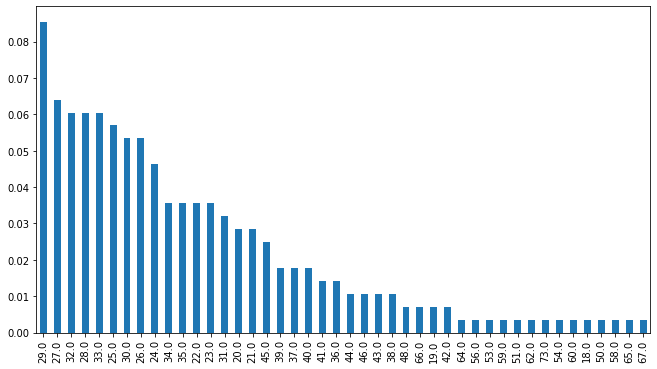

In [ ]:
print('The mean of "Age" is %.2f' %(df["user_age"].mean(skipna=True)))
print('The median of "Age" is %.2f' %(df["user_age"].median(skipna=True)))

#Use median for NaN - This is has no importance as both will fall into same Bin later...
df['user_age'].fillna(df['user_age'].median(skipna=True) , inplace=True)
df[df['target']==True]['user_age'].value_counts(normalize=True).plot.bar(figsize=(11, 6) , sort_columns=True)

#### coast

In [ ]:
df['coast'].isnull().sum()

1155

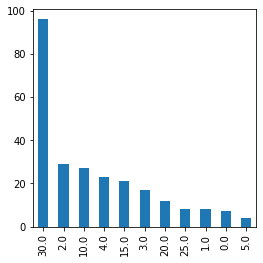

In [ ]:
df[df['target']==True]['coast'].value_counts(normalize=False).plot(figsize=(4, 4) ,kind='bar')

Nulls Before:  1155
After:  1    11242
0     1155
Name: is_close_to_coast, dtype: int64


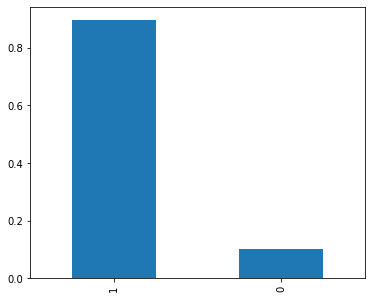

In [ ]:
print('Nulls Before: ' , df['coast'].isnull().sum())

df['coast'].fillna(-1 , inplace=True)
df['is_close_to_coast']= df.coast.apply(lambda x : 1 if x>=0 else 0 ).astype('int')
df=df.drop(columns='coast')

print('After: ', df['is_close_to_coast'].value_counts())
df[df['target']==True]['is_close_to_coast'].value_counts(normalize=True).plot.bar(figsize=(6, 5) , sort_columns=True)

#### portable elctronics

0    8364
1    4033
Name: portable_electronics, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


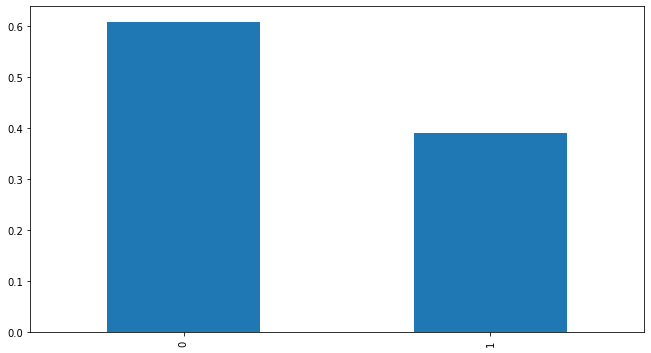

In [ ]:
df['portable_electronics'].fillna(0 , inplace=True)
df.portable_electronics=df.portable_electronics.astype('int64')
print(df['portable_electronics'].value_counts() )
print(df[df['target']==True]['portable_electronics'].value_counts(normalize=True).plot.bar(figsize=(11, 6) , sort_columns=True))


#### fire_housing_proximity

In [ ]:
#CLEAN of invalid values
df['fire_housing_proximity'] = df.fire_housing_proximity.str.extract('(\d+)')
df['fire_housing_proximity'].value_counts()

1    6391
2    3574
3    1616
4     598
5     176
6      28
7       9
8       5
Name: fire_housing_proximity, dtype: int64

#### Product

In [ ]:
df['product'].fillna('other' , inplace=True)
df['product'].value_counts()

ho4    12127
ho6      153
ho3      117
Name: product, dtype: int64

#### Card_type

In [ ]:
df['card_type'].fillna('other' , inplace=True)
df['card_type'].value_counts()

debit      7131
credit     5029
prepaid     185
other        52
Name: card_type, dtype: int64

#### previous_policies

In [ ]:
df['previous_policies'].value_counts()

0    9898
1    2152
2     275
3      48
4      19
5       3
7       1
6       1
Name: previous_policies, dtype: int64

#### State
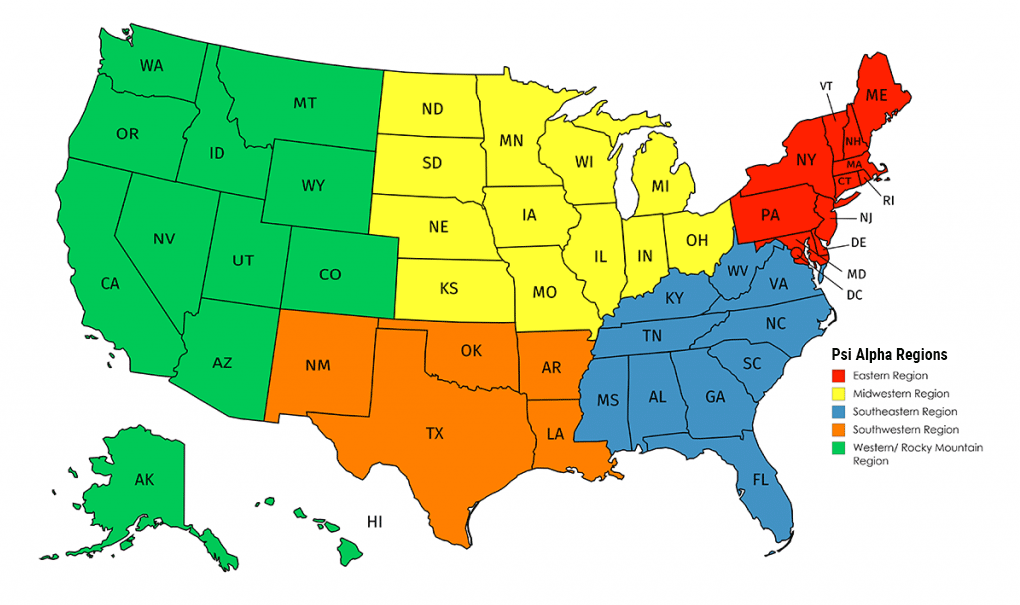

In [ ]:
#Conver state to 1-5 regions:

mapping_dict = {
"state": {
"WA": 1,
"OR": 1,
"ID": 1,
"MT": 1,
"WY": 1,
"CA": 1,
"NV": 1,
"UT": 1,
"CO": 1,
"AZ": 1,
"AK": 1,
"HI": 1,
"ND": 2,
"MN": 2,
"SD": 2,
"ND": 2,
"WI": 2,
"NE": 2,
"IA": 2,
"MI": 2,
"KS": 2,
"MO": 2,
"IL": 2,
"IN": 2,
"OH": 2,
"NM": 3,
"TX": 3,
"OK": 3,
"AR": 3,
"LA": 3,
"ME": 4,
"VT": 4,
"MH": 4,
"MA": 4,
"CT": 4,
"RI": 4,
"NY": 4,
"PA": 4,
"NJ": 4,
"DE": 4,
"MD": 4,
"DC": 4,
"WA": 5,
"VA": 5,
"KY": 5,
"NC": 5,
"TN": 5,
"SC": 5,
"MS": 5,
"AL": 5,
"GA": 5,
"FL": 5
}
}
df['state']=df[['state']].replace(mapping_dict)

1    4294
3    3352
4    3023
2    1345
5     383
Name: state, dtype: int64


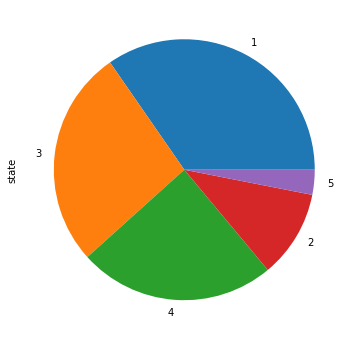

In [ ]:
print(df['state'].value_counts())
df['state'].value_counts().plot(figsize=(11, 6) ,kind='pie')

### Feature Conversion
---
**Ordinal Values (can be logically sorted)** - Use Label Encoding, Target encoding, Probability ratio encoding: `['product','coast','fire_housing_proximity','user_age','previous_policies']`

**Nominal features (Cannot be logically sorted)** - Use One hot encoding / binary encoder:
`['state','card_type','portable_electronics','has_fire_alarm',has_burglar_alarm']`

#### Prev_policies

In [ ]:
#binary encoding

df['prev_policies']= df.previous_policies.apply(lambda x : 0 if x ==0 else 1 ).astype('int')

#df.drop(labels=['previous_policies'] , axis=1 , inplace=True)
print(df['prev_policies'].value_counts())
df=df.drop(columns='previous_policies')

0    9898
1    2499
Name: prev_policies, dtype: int64


#### user_age

In [ ]:
#user_age - Bin + label encoding
#Devide user_age to bins:
# 1 = age 0-30
# 2 = age 31-50
# 3 = age 51-70
# 4 = age 71-200

Labels = ['1','2','3','4']
Bins = [0,30,50,70,200]
df['user_age'] = pd.cut(df['user_age'], bins=Bins , labels=Labels)


1    7467
2    4197
3     683
4      50
Name: user_age, dtype: int64


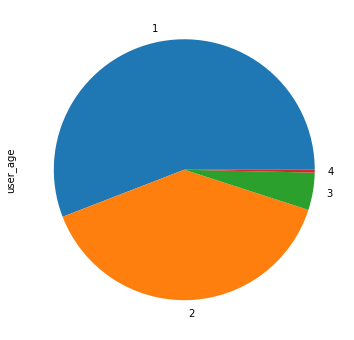

In [ ]:
print(df['user_age'].value_counts())
df[df['target']==True]['user_age'].value_counts(normalize=True).plot(figsize=(11, 6) ,kind='pie')


#### has_fire_alarm


In [ ]:
df.has_fire_alarm=df.has_fire_alarm.astype('int64')

#### Has burgler Alarm

In [ ]:
df.has_burglar_alarm=df.has_burglar_alarm.astype('int64')

####fire_housing_proximity

In [ ]:
df.fire_housing_proximity=df.fire_housing_proximity.astype('category')

#### state

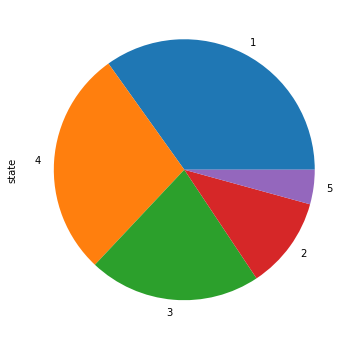

In [ ]:
df.state=df.state.astype('category')
df[df['target']==True]['state'].value_counts(normalize=True).plot(figsize=(11, 6) ,kind='pie')


#### coast

In [ ]:
# df.coast=df.coast.astype('category')
# df = df.drop(columns='coast')


#### Product

In [ ]:
label_enc = LabelEncoder()
label_enc.fit(df['product'])
df['product'] = label_enc.transform(df['product'])
df['product'].value_counts()

1    12127
2      153
0      117
Name: product, dtype: int64

#### Card_type

In [ ]:
label_enc = LabelEncoder()
label_enc.fit(df['card_type'])
df['card_type'] = label_enc.transform(df['card_type'])
df['card_type'].value_counts()

1    7131
0    5029
3     185
2      52
Name: card_type, dtype: int64

#### Target

0    12116
1      281
Name: target, dtype: int64


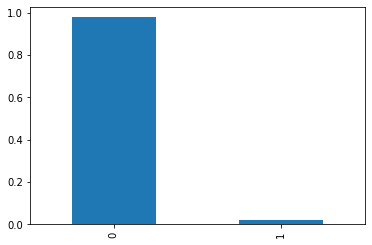

In [ ]:
df.target=df.target.astype('int64')
print(df['target'].value_counts())
df['target'].value_counts(normalize=True).plot(figsize=(6, 4) ,kind='bar')

#### Remove features

In [ ]:
#Remove un-importnat features
drop_list = ['id','user_id','postal_code','square_ft','high_risk_dog','product'] #'card_type'[]
df = df.drop(drop_list , axis=1)
df.head(2)

,state,has_fire_alarm,has_burglar_alarm,portable_electronics,fire_housing_proximity,user_age,card_type,target,is_close_to_coast,prev_policies
0,3,1,1,0,5,2,0,0,0,0
1,2,1,0,1,1,1,1,0,1,0


### Get Dummies

In [ ]:
# df = pd.concat([df , pd.get_dummies(df['coast'],prefix='coast')] ,axis=1 )
# df = pd.get_dummies(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12397 entries, 0 to 12396
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   state                   12397 non-null  category
 1   has_fire_alarm          12397 non-null  int64   
 2   has_burglar_alarm       12397 non-null  int64   
 3   portable_electronics    12397 non-null  int64   
 4   fire_housing_proximity  12397 non-null  category
 5   user_age                12397 non-null  category
 6   card_type               12397 non-null  int64   
 7   target                  12397 non-null  int64   
 8   is_close_to_coast       12397 non-null  int64   
 9   prev_policies           12397 non-null  int64   
dtypes: category(3), int64(7)
memory usage: 715.2 KB


In [ ]:
df.drop_duplicates().info()
df.reset_index

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1677 entries, 0 to 12393
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   state                   1677 non-null   category
 1   has_fire_alarm          1677 non-null   int64   
 2   has_burglar_alarm       1677 non-null   int64   
 3   portable_electronics    1677 non-null   int64   
 4   fire_housing_proximity  1677 non-null   category
 5   user_age                1677 non-null   category
 6   card_type               1677 non-null   int64   
 7   target                  1677 non-null   int64   
 8   is_close_to_coast       1677 non-null   int64   
 9   prev_policies           1677 non-null   int64   
dtypes: category(3), int64(7)
memory usage: 110.5 KB


<bound method DataFrame.reset_index of       state  has_fire_alarm  ...  is_close_to_coast  prev_policies
0         3               1  ...                  0              0
1         2               1  ...                  1              0
2         2               1  ...                  1              0
3         3               1  ...                  0              0
4         3               0  ...                  0              0
...     ...             ...  ...                ...            ...
12392     3               0  ...                  1              1
12393     3               1  ...                  1              0
12394     3               0  ...                  1              0
12395     3               1  ...                  1              0
12396     3               1  ...                  1              0

[12397 rows x 10 columns]>

#### Summary

In [ ]:
df.dtypes

state                     category
has_fire_alarm               int64
has_burglar_alarm            int64
portable_electronics         int64
fire_housing_proximity    category
user_age                  category
card_type                    int64
target                       int64
is_close_to_coast            int64
prev_policies                int64
dtype: object

In [ ]:
df.isnull().sum()

state                     0
has_fire_alarm            0
has_burglar_alarm         0
portable_electronics      0
fire_housing_proximity    0
user_age                  0
card_type                 0
target                    0
is_close_to_coast         0
prev_policies             0
dtype: int64

### Data split

In [ ]:
#X,y split & Train/Test split
X= df.drop('target',axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.75
                                                    ,test_size=0.25
                                                    ,shuffle=True
                                                    ,random_state = 1
                                                    ,stratify=df.target
                                                    )
y_train = y_train.to_frame()
y_test = y_test.to_frame()
# X_train = X_train.to_frame()
# X_test = X_test.to_frame()
X_col = X_train.columns
X_col

Index(['state', 'has_fire_alarm', 'has_burglar_alarm', 'portable_electronics',
       'fire_housing_proximity', 'user_age', 'card_type', 'is_close_to_coast',
       'prev_policies'],
      dtype='object')

In [ ]:
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (9297, 9)
X_test:  (3100, 9)
y_train:  (9297, 1)
y_test:  (3100, 1)


In [ ]:
print("X_train: ", type(X_train))
print("X_test: ",type(X_test))
print("y_train: ",type(y_train))
print("y_test: ",type(y_test))

X_train:  <class 'pandas.core.frame.DataFrame'>
X_test:  <class 'pandas.core.frame.DataFrame'>
y_train:  <class 'pandas.core.frame.DataFrame'>
y_test:  <class 'pandas.core.frame.DataFrame'>


In [ ]:
print('y_train: ' ,y_train.value_counts(),'\n')
print('y_test: ' ,y_test.value_counts())

y_train:  target
0         9086
1          211
dtype: int64 

y_test:  target
0         3030
1           70
dtype: int64


### Scaling

In [ ]:
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

### Imbalanced Data

##### SOMTE-TOMEK (Not in use - as the results are identical to)

In [ ]:
## With SMOTE-Tomek Links method

# Define SMOTE-Tomek Links
resample_tomek=SMOTETomek(tomek=TomekLinks(sampling_strategy='auto'), random_state=1)
X_tomek_train , y_tomek_train = resample_tomek.fit_resample(X_train, y_train)

#Check target class after:
print('smote-tomke: ' , pd.DataFrame(y_tomek_train , columns=['target']).value_counts() )

smote-tomke:  target
0         9086
1         9085
dtype: int64


##### SMOTE

In [ ]:
## With SMOTE method
resample_smote=SMOTE(sampling_strategy='minority', random_state=1)
X_smote_train , y_smote_train = resample_smote.fit_resample(X_train, y_train)

#Check target class after:
print('After Smote: ' ,pd.DataFrame(y_smote_train , columns=['target']).value_counts() )

After Smote:  target
1         9086
0         9086
dtype: int64


#### Imbalance methods evaluation

In [ ]:
# Define model
model=RandomForestClassifier(criterion='gini')

# Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [ ]:
### SMOTE-Tomek evaluation:

# Define pipeline
pipeline=Pipeline(steps=[('r', resample_tomek), ('m', model)])


# model
scoring=['accuracy','precision','recall']
scores = cross_validate(pipeline, X_tomek_train, y_tomek_train, scoring=scoring, cv=cv, n_jobs=-1)

# summarize performance
print('SMOTE-Tomek accuracy (mean): %.4f' % np.mean(scores['test_accuracy']))
print('SMOTE-Tomek precision (mean): %.4f' % np.mean(scores['test_precision']))
print('SMOTE-Tomek recall (mean): %.4f' % np.mean(scores['test_recall']))

SMOTE-Tomek accuracy (mean): 0.8865
SMOTE-Tomek precision (mean): 0.8858
SMOTE-Tomek recall (mean): 0.8875


In [ ]:
### SMOTE evaluation:

# Define pipeline
pipeline=Pipeline(steps=[('r', resample_smote), ('m', model)])

# Evaluate model
scoring=['accuracy','precision','recall']
scores = cross_validate(pipeline, X_smote_train, y_smote_train, scoring=scoring, cv=cv, n_jobs=-1)

# summarize performance
print('smote accuracy (mean): %.4f' % np.mean(scores['test_accuracy']))
print('smote precision (mean): %.4f' % np.mean(scores['test_precision']))
print('smote recall (mean): %.4f' % np.mean(scores['test_recall']))

smote accuracy (mean): 0.8867
smote precision (mean): 0.8853
smote recall (mean): 0.8888


#### Choose the imblancing method

In [ ]:
#Save the Original X,y train
X_no_res_train = X_train
y_no_res_train = y_train

#Assign the selected methood to X,y train
X_train = X_smote_train
y_train = y_smote_train

#### Decision Tree

In [ ]:
dt = DecisionTreeClassifier(criterion = 'gini', max_depth=7, max_leaf_nodes=16, random_state=1  )
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=16,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

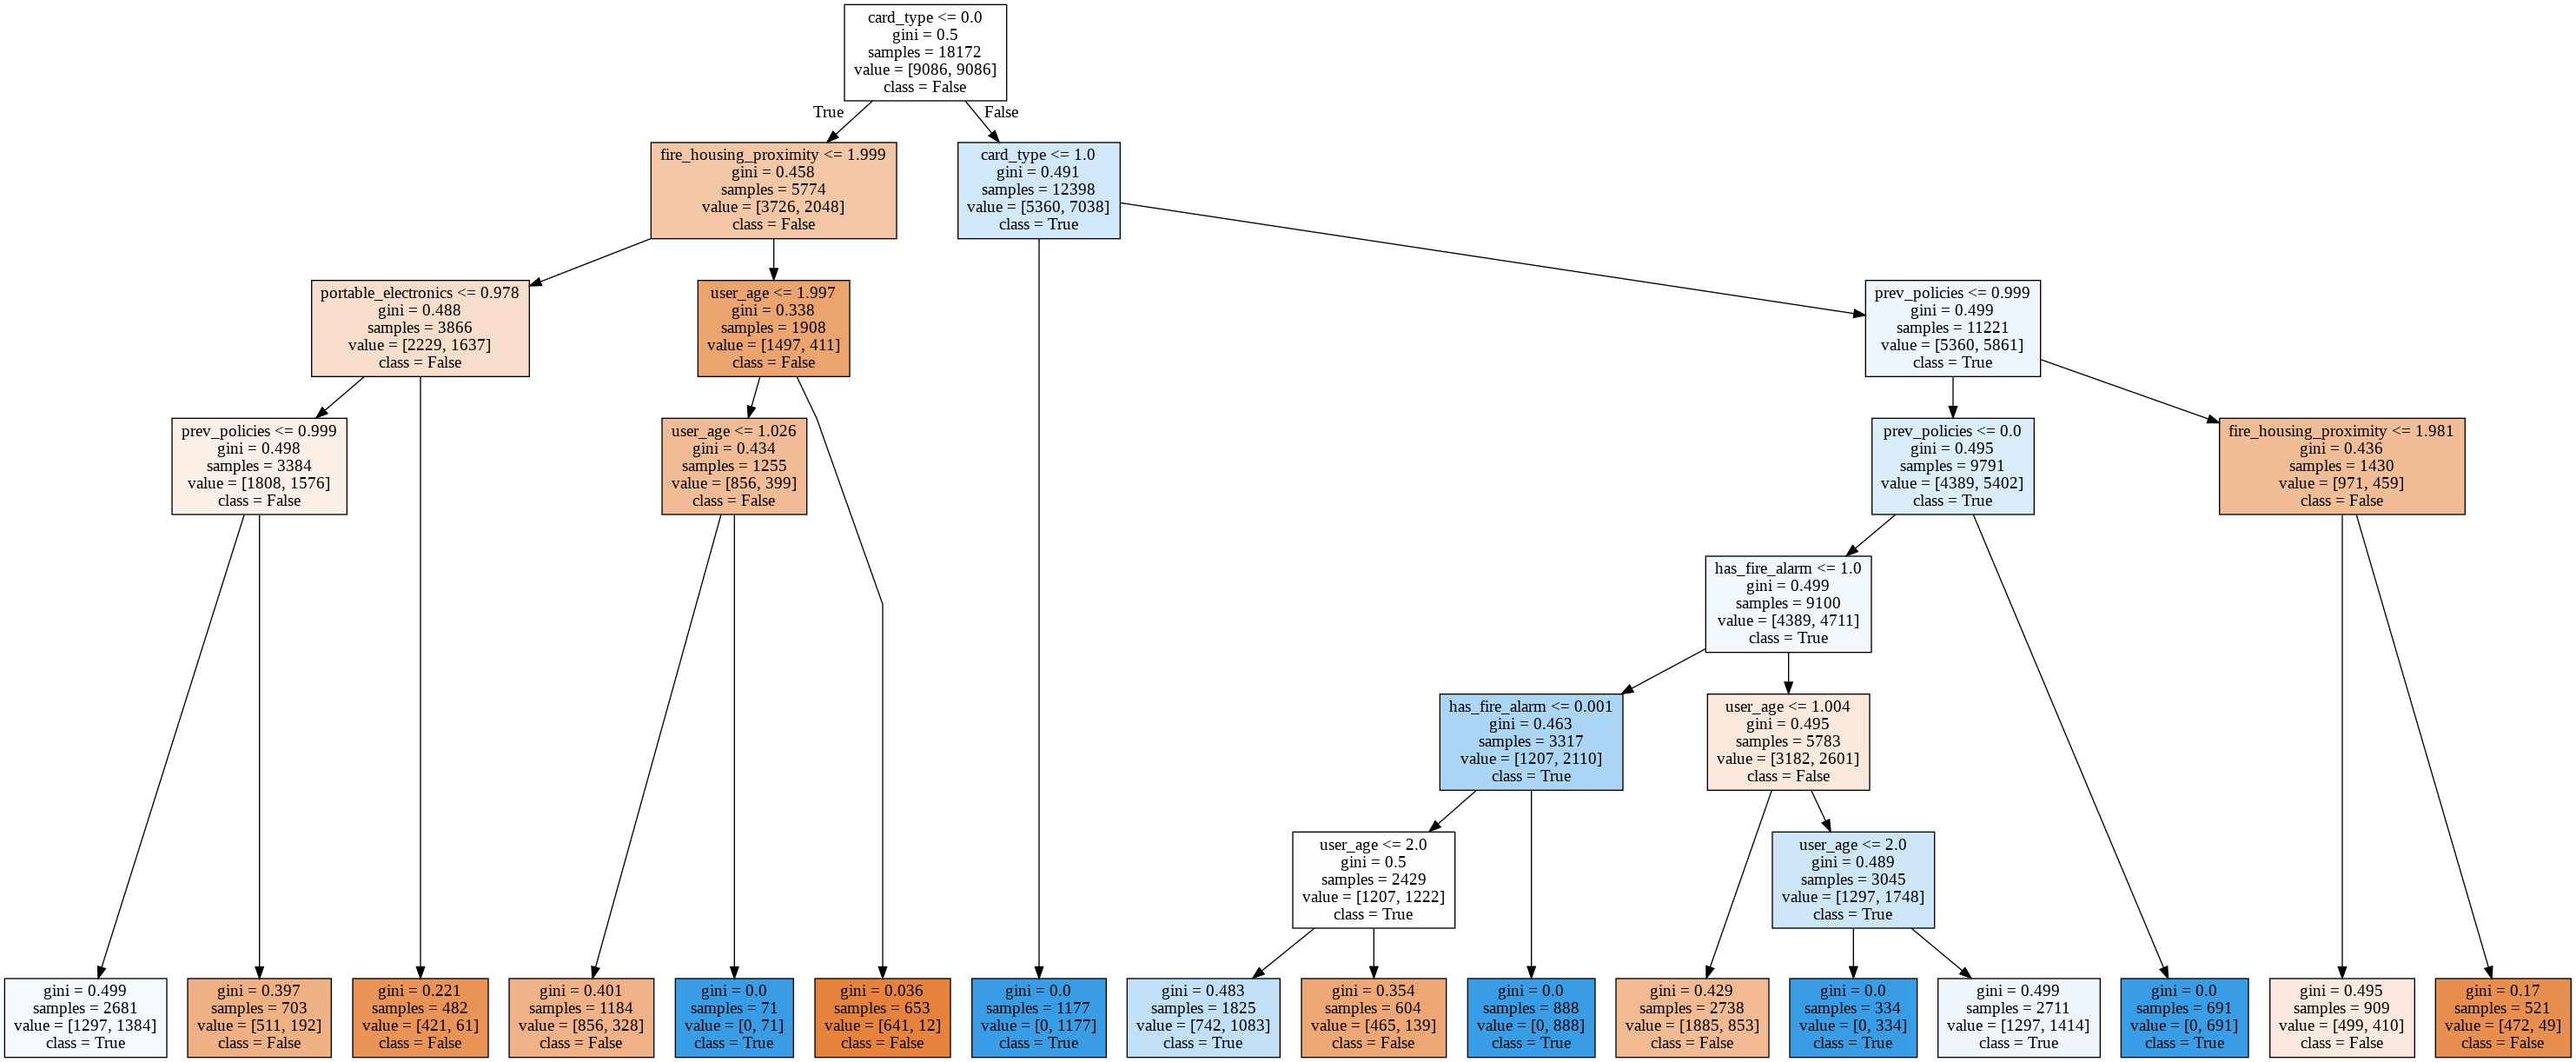

In [ ]:
dot_data = StringIO()  
export_graphviz(dt, out_file=dot_data, feature_names=X_col, 
                leaves_parallel=True, filled=True, class_names=['False', 'True'])  
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
Image(graph.create_png(), width=1200)

In [ ]:
pd.Series(dt.feature_importances_,
          index=X_col).sort_values(ascending=False)

card_type                 0.312142
user_age                  0.222668
prev_policies             0.184103
has_fire_alarm            0.173012
fire_housing_proximity    0.072154
portable_electronics      0.035920
is_close_to_coast         0.000000
has_burglar_alarm         0.000000
product                   0.000000
state                     0.000000
dtype: float64

## Model

Models:   
Random Forest (+gridsearch) + scoring (f1,precision, recall , accuracy, ROC)
  3.2 Logistics Reg
  3.3 SVM





### RandomForest

In [ ]:
#The number of attributes for a split:  (This is BKM. And unless specified by the hyperparam, It does it automatically)
num_features_for_split = math.sqrt(X_train.shape[1])
print(num_features_for_split)

3.0


In [ ]:
#Override X,y train with imbalanced("not resampled") data (for testing purpose):
# X_train = X_no_res_train
# y_train = y_no_res_train
print('balance: ' , pd.DataFrame(y_train , columns=['target']).value_counts() )

balance:  target
1         9086
0         9086
dtype: int64


In [ ]:
RF_prm_grid = {'n_estimators':[100, 200]
               ,'max_depth':[8, 12, 16]
               ,'criterion':['gini','entropy']
              #  ,'class_weight':['balanced']
               ,'bootstrap':[False,True]
               #,'max_features': [0.2,0.5,4,5,'sqrt'] #auto=sqrt
               }

#### Recall score

In [ ]:
gs_rf_f1 = GridSearchCV(RandomForestClassifier(random_state=1), param_grid=RF_prm_grid, scoring = 'recall',cv=5)
gs_rf_f1.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=1,
                                   

In [ ]:
print("Recall parameters: {}".format(gs_rf_f1.best_params_))
print("Recall score is: {:.3f}".format(gs_rf_f1.best_score_))

Recall parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 16, 'n_estimators': 100}
Recall score is: 0.891


In [ ]:
rf = RandomForestClassifier(n_estimators=100
                            # ,max_features=0.2 
                            # ,class_weight='balanced'
                            ,max_depth=16
                            ,criterion='gini'
                            ,random_state=1
                            ,bootstrap=False
                            )
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=16, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [ ]:
y_train_pred = rf.predict(X_train)
y_pred = rf.predict(X_test)

print("Train recall scor:", f1_score(y_train,y_train_pred))

rf_f1_gs = f1_score(y_test, y_pred)
print("Test recall-scor:", rf_f1_gs)

Train recall scor: 0.8930333423692057
Test recall-scor: 0.02696629213483146


#### f1 Score

In [ ]:
gs_rf_f1 = GridSearchCV(RandomForestClassifier(random_state=1), param_grid=RF_prm_grid,scoring='f1',cv=5)
gs_rf_f1.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=1,
                                   

In [ ]:
print("f1 parameters: {}".format(gs_rf_f1.best_params_))
print("f1 score is: {:.3f}".format(gs_rf_f1.best_score_))

f1 parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 16, 'n_estimators': 100}
f1 score is: 0.886


In [ ]:
rf = RandomForestClassifier(n_estimators=100
                            # ,max_features=0.2 
                            # ,class_weight='balanced'
                            ,max_depth=16
                            ,criterion='gini'
                            ,random_state=1
                            ,bootstrap=False
                            )
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=16, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [ ]:
y_train_pred = rf.predict(X_train)
y_pred = rf.predict(X_test)

print("Train f1-score:", f1_score(y_train,y_train_pred))

rf_f1_gs = f1_score(y_test, y_pred)
print("Test f1-score:", rf_f1_gs)

Train f1-score: 0.8930333423692057
Test f1-score: 0.02696629213483146


In [ ]:
cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(cm,
             index=rf.classes_,
             columns=rf.classes_)

,0,1
0,2661,369
1,64,6


#### ROC_AUC Score

In [ ]:
gs_rf_auc = GridSearchCV(RandomForestClassifier(random_state=1),param_grid=RF_prm_grid,scoring='roc_auc',cv=5)
gs_rf_auc.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=1,
                                   

In [ ]:
print("Roc parameters: {}".format(gs_rf_auc.best_params_))
print("Roc score is {:.3f}".format(gs_rf_auc.best_score_))

Roc parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 16, 'n_estimators': 200}
Roc score is 0.966


In [ ]:
rf = RandomForestClassifier(n_estimators=200
                            ,max_depth=16 
                            # ,max_features=5 
                            # ,class_weight='balanced'
                            ,criterion='gini'
                            ,bootstrap=True
                            ,random_state=1
                            )
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=16, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [ ]:
y_train_pred = rf.predict(X_train)
y_pred = rf.predict(X_test)

print("Train roc-auc:", roc_auc_score(y_train,y_train_pred))

rf_auc_gs = roc_auc_score(y_test,y_pred)
print('Test roc-auc:',rf_auc_gs)

Train roc-auc: 0.8915364296720228
Test roc-auc: 0.48229608675153224


In [ ]:
cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(cm,
             index=rf.classes_,
             columns=rf.classes_)

,0,1
0,2663,367
1,64,6


### SVM

In [ ]:
svm_clf = SVC(random_state=1, tol=1e-3 ,kernel='sigmoid')
svm_clf.fit(X_train, y_train )

y_train_pred = svm_clf.predict(X_train)
y_pred = svm_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(cm, index=dt.classes_, columns=dt.classes_)
print('Classification report: \n', classification_report(y_test,y_pred , ))

Classification report: 
               precision    recall  f1-score   support

           0       0.98      0.53      0.69      3030
           1       0.02      0.47      0.04        70

    accuracy                           0.53      3100
   macro avg       0.50      0.50      0.37      3100
weighted avg       0.96      0.53      0.68      3100



In [ ]:
svm_clf = SVC(random_state=1, tol=1e-5 ,kernel='linear')
svm_clf.fit(X_train, y_train)

y_train_pred = svm_clf.predict(X_train)
y_pred = svm_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(cm, index=dt.classes_, columns=dt.classes_)
print('Classification report: \n', classification_report(y_test,y_pred , ))

Classification report: 
               precision    recall  f1-score   support

           0       0.98      0.40      0.57      3030
           1       0.02      0.66      0.05        70

    accuracy                           0.41      3100
   macro avg       0.50      0.53      0.31      3100
weighted avg       0.96      0.41      0.56      3100



### Logistics Regression

In [ ]:
lr_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'tol': [0.01 , 0.001, 0.0001 ]}
gs_lr_f1 = GridSearchCV(LogisticRegression(random_state=1), param_grid=lr_param_grid, scoring='f1', cv=10)
gs_lr_f1.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=1, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'tol': [0.01, 0.001, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [ ]:
print("LR parameters: {}".format(gs_lr_f1.best_params_))
print("LR score is {:.3f}".format(gs_lr_f1.best_score_))

LR parameters: {'C': 0.01, 'tol': 0.01}
LR score is 0.578


In [ ]:
log_reg = LogisticRegression(C=0.01, tol=0.01, random_state=1)
log_reg.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.01, verbose=0,
                   warm_start=False)

In [ ]:
y_train_pred = log_reg.predict(X_train)
y_pred = log_reg.predict(X_test)

print("Train f1-score:", f1_score(y_train,y_train_pred))

log_reg_f1_gs = f1_score(y_test, y_pred)
print("Test f1-score:", log_reg_f1_gs)



Train f1-score: 0.5806968790081232
Test f1-score: 0.0466977985323549


In [ ]:
cm = confusion_matrix(y_test, y_pred)

pd.DataFrame(cm,
             index=log_reg.classes_,
             columns=log_reg.classes_)

,0,1
0,1636,1394
1,35,35


#### ROC_AUC

In [ ]:
lr_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'tol': [0.01 , 0.001, 0.0001 ]}
gs_lr_f1 = GridSearchCV(LogisticRegression(random_state=1), param_grid=lr_param_grid, scoring='roc_auc', cv=10)
gs_lr_f1.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=1, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'tol': [0.01, 0.001, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [ ]:
print("LR parameters: {}".format(gs_lr_f1.best_params_))
print("LR score is {:.3f}".format(gs_lr_f1.best_score_))

LR parameters: {'C': 10, 'tol': 0.01}
LR score is 0.575


In [ ]:
log_reg = LogisticRegression(C=10, tol=0.01, random_state=1)
log_reg.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.01, verbose=0,
                   warm_start=False)

In [ ]:
y_train_pred = log_reg.predict(X_train)
y_pred = log_reg.predict(X_test)

print("Train roc_auc-score:", f1_score(y_train,y_train_pred))

log_reg_f1_gs = f1_score(y_test, y_pred)
print("Test roc_auc-score:", log_reg_f1_gs)



Train roc_auc-score: 0.5788047808764939
Test roc_auc-score: 0.044619422572178484


In [ ]:
cm = confusion_matrix(y_test, y_pred)

pd.DataFrame(cm,
             index=log_reg.classes_,
             columns=log_reg.classes_)

,0,1
0,1610,1420
1,36,34


#### Feature selection - Not in Use

In [ ]:
df

In [ ]:
cols = ['state','has_fire_alarm', 'has_burglar_alarm','product_0','product_1','card_type_0','card_type_1','card_type_2',
       'portable_electronics', 'coast', 'fire_housing_proximity',
       'prev_policies_bool', 'age_cat']

X = df[cols]
y = df['target']

#oversample = SMOTE()
#X, y = oversample.fit_resample(X, y)


# Build a logreg and compute the feature importances
model = LogisticRegression()
# create the RFE model and select 8 attributes
rfe = RFE(model, 8)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
print('Selected features: %s' % list(X.columns[rfe.support_]))


In [ ]:
df_selected = df[['has_fire_alarm', 'has_burglar_alarm', 'product_0', 'product_1', 'card_type_1', 'card_type_2', 'portable_electronics', 'prev_policies_bool']]


In [ ]:
from sklearn.feature_selection import RFECV
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


In [ ]:
#Ratio of TRUE for Products
df[df['target']==True].groupby('product')['product'].value_counts() / df[df['target']==True]['target'].size

In [ ]:
sns.barplot('coast', 'target', data=df, color="darkturquoise")
plt.show()